In [1]:
import pandas as pd
import numpy as  np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity


# 分群
from sklearn.cluster import KMeans

# 協同過濾
from surprise import Dataset, Reader, KNNBasic, NMF, SVD
from surprise.model_selection import train_test_split
from surprise import accuracy

# 深度學習 (embedding 用)
import tensorflow as tf
from tensorflow.keras import layers, Model



2025-05-01 04:04:22.199548: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746072262.442786      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746072262.512763      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


EDA (Exploratory Data Analysis)

In [2]:
df = pd.read_csv('/kaggle/input/200k-spotify-songs-light-dataset/light_spotify_dataset.csv')

print(df.shape)
print(df.columns)
df.head()

#features = ['artist', 'song', 'emotion', 'variance', 'Genre', 'Release Date', 'Key','Tempo', 'Loudness', 'Explicit', 'Popularity', 'Energy', 'Danceability', 'Positiveness', 'Speechiness', 'Liveness', 'Acousticness','Instrumentalness']

#df = df[features]

(236988, 18)
Index(['artist', 'song', 'emotion', 'variance', 'Genre', 'Release Date', 'Key',
       'Tempo', 'Loudness', 'Explicit', 'Popularity', 'Energy', 'Danceability',
       'Positiveness', 'Speechiness', 'Liveness', 'Acousticness',
       'Instrumentalness'],
      dtype='object')


,artist,song,emotion,variance,Genre,Release Date,Key,Tempo,Loudness,Explicit,Popularity,Energy,Danceability,Positiveness,Speechiness,Liveness,Acousticness,Instrumentalness
0,ABBA,She's My Kind Of Girl,joy,0.447619,pop,2014,F Maj,128,-6.00,No,31,78,56,60,3,31,7,0
1,ABBA,"Andante, Andante",love,0.202222,pop,1980,A# Maj,102,-10.72,No,59,36,52,38,2,7,68,0
2,ABBA,As Good As New,sadness,0.300881,pop,1979,E Maj,139,-5.70,No,50,78,85,97,3,8,20,2
3,ABBA,Bang,joy,0.355000,pop,1975,F Maj,132,-3.00,No,52,76,50,89,3,32,3,0
4,ABBA,Bang-A-Boomerang,joy,0.355000,pop,1975,F Maj,132,-3.00,No,52,76,50,89,3,32,3,0


In [3]:
print(df.isnull().sum())
df.describe()

artist              0
song                8
emotion             0
variance            0
Genre               0
Release Date        0
Key                 0
Tempo               0
Loudness            0
Explicit            0
Popularity          0
Energy              0
Danceability        0
Positiveness        0
Speechiness         0
Liveness            0
Acousticness        0
Instrumentalness    0
dtype: int64


,variance,Release Date,Tempo,Loudness,Popularity,Energy,Danceability,Positiveness,Speechiness,Liveness,Acousticness,Instrumentalness
count,236988.000000,236988.000000,236988.000000,236988.000000,236988.000000,236988.000000,236988.000000,236988.000000,236988.000000,236988.000000,236988.000000,236988.000000
mean,0.658932,2008.472826,120.609685,-8.038657,40.003705,62.369166,59.127492,47.656966,11.748042,19.905333,26.156194,5.440052
std,0.320735,14.756158,28.966358,3.842215,18.770245,22.083376,17.069117,23.801800,12.443653,16.551294,29.047331,17.662526
min,-1.000000,1900.000000,33.000000,-46.770000,0.000000,0.000000,6.000000,0.000000,2.000000,1.000000,0.000000,0.000000
25%,0.833514,2002.000000,97.000000,-9.890000,27.000000,48.000000,48.000000,29.000000,4.000000,10.000000,2.000000,0.000000
50%,0.833514,2015.000000,120.000000,-7.190000,39.000000,64.000000,60.000000,47.000000,6.000000,13.000000,14.000000,0.000000
75%,0.833514,2019.000000,140.000000,-5.370000,52.000000,80.000000,72.000000,66.000000,16.000000,25.000000,44.000000,0.000000
max,1.000000,2024.000000,200.000000,3.740000,100.000000,100.000000,99.000000,99.000000,97.000000,100.000000,100.000000,100.000000


# Exploratory Data Analysis (EDA)
## Emotion Distribution

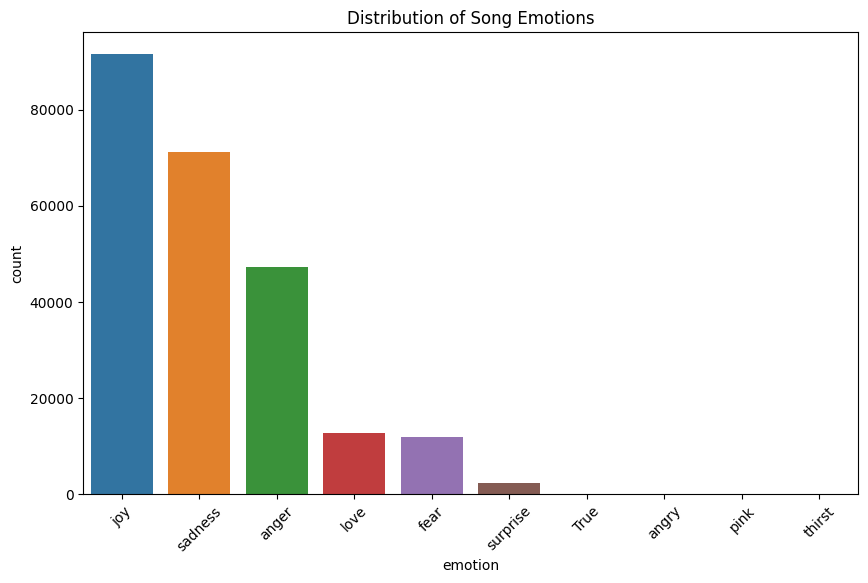

In [4]:
plt.figure(figsize=(10,6))
sns.countplot(data=df,x='emotion',order=df['emotion'].value_counts().index)
plt.title('Distribution of Song Emotions')
plt.xticks(rotation=45)
plt.show()

In [5]:
df['emotion'] = df['emotion'].replace('angry', 'anger')

## Genre Distribution

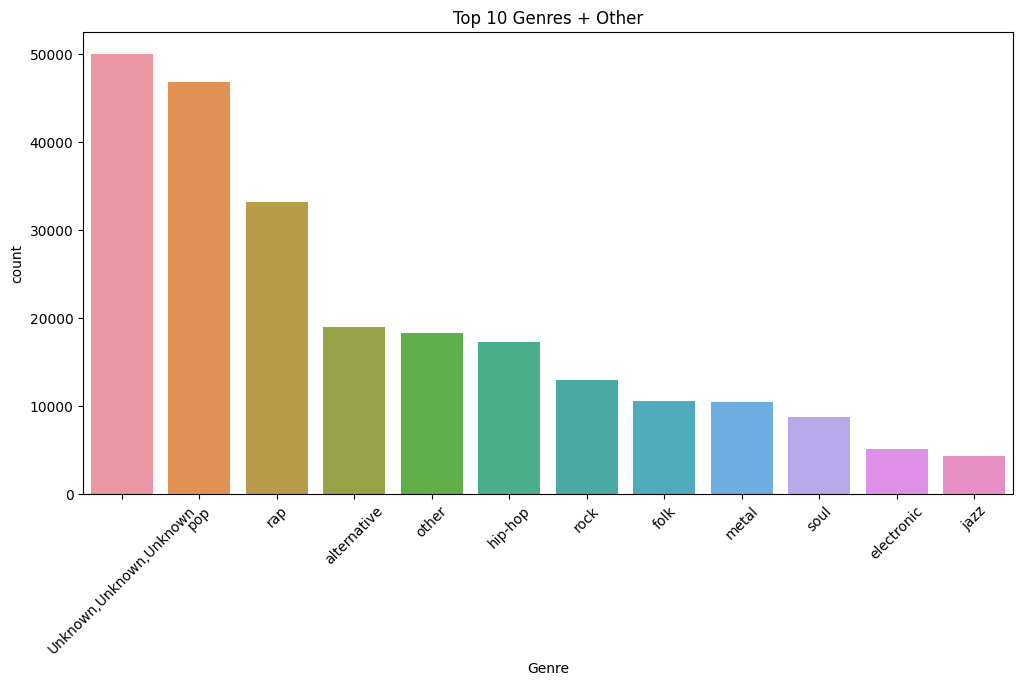

In [6]:
top_genres = df['Genre'].value_counts().nlargest(11).index
df['Genre']=df['Genre'].apply(lambda x: x if x in top_genres else 'other')

plt.figure(figsize=(12,6))
sns.countplot(data=df, x='Genre', order=df['Genre'].value_counts().index)
plt.title('Top 10 Genres + Other')
plt.xticks(rotation=45)
plt.show()

Genre
other          0.288120
pop            0.197829
rap            0.140108
alternative    0.080380
hip-hop        0.073071
rock           0.054669
folk           0.044812
metal          0.044268
soul           0.036884
electronic     0.021706
jazz           0.018153
Name: proportion, dtype: float64


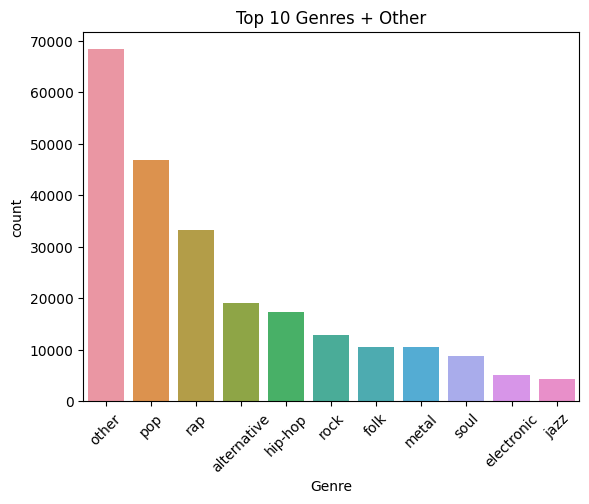

In [7]:
df['Genre']=df['Genre'].replace('Unknown,Unknown,Unknown','other')
print(df['Genre'].value_counts(normalize=True))
sns.countplot(data=df, x='Genre', order=df['Genre'].value_counts().index)
plt.title('Top 10 Genres + Other')
plt.xticks(rotation=45)
plt.show()

## Popularity Distribution

Distribution is close to normal with a slight right tail. About40% of songs have popularity below 30, indicating a notable portion of less popular or niche tracks.


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


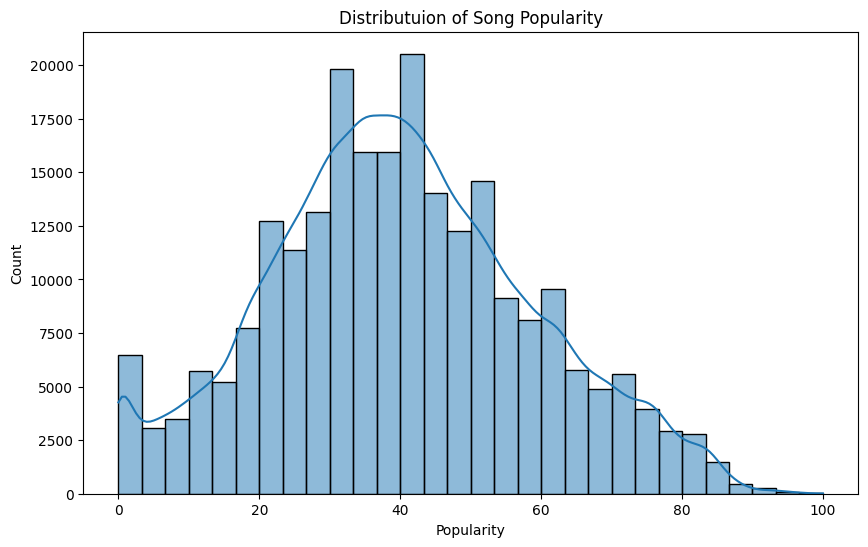

In [8]:
plt.figure(figsize=(10,6))
sns.histplot(df['Popularity'],bins=30, kde=True)
plt.title('Distributuion of Song Popularity')
plt.show()

## Word Cloud of Song Titles

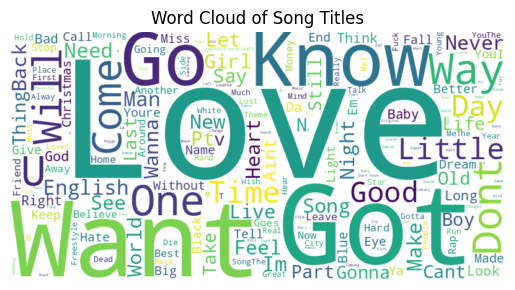

In [9]:
from wordcloud import WordCloud

text =''.join(df['song'].dropna())

wordcloud = WordCloud(width=800,height=400, background_color='white').generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud of Song Titles')
plt.axis('off')
plt.show()

# 3.1 Emotion-Based Song Recommender

In [10]:
import difflib

# 定義模糊匹配函數
def fuzzy_match_emotion(user_input, valid_emotions):
    closest = difflib.get_close_matches(user_input, valid_emotions, n=1, cutoff=0.5)
    return closest[0] if closest else None

# 主推薦函數（含別名 + 模糊比對 + fallback）
def recommend_by_emotion_fuzzy(emotion_label, top_n=10):
    # 定義別名對照表
    emotion_aliases = {
        'happy': 'joy',
        'cheerful': 'joy',
        'romance': 'love',
        'romantic': 'love',
        'depressed': 'sadness',
        'mad': 'anger',
        'rage': 'anger',
        'relax': 'joy',
        'chill': 'joy',
        'cry': 'sadness'
    }

    valid_emotions = df['emotion'].unique().tolist()

    # 別名轉換
    if emotion_label in emotion_aliases:
        emotion_label = emotion_aliases[emotion_label]

    # 空值處理（未輸入情緒）
    if not emotion_label:
        print("No emotion specified. Showing random recommendations.")
        return df.sample(n=top_n)[['song', 'artist', 'Genre', 'Popularity']]

    # 模糊比對：找出最相近的有效情緒
    matched_emotion = fuzzy_match_emotion(emotion_label, valid_emotions)

    if not matched_emotion:
        print(f"No close match for emotion: '{emotion_label}'. Showing random recommendations.")
        return df.sample(n=top_n)[['song', 'artist', 'Genre', 'Popularity']]

    # 正常推薦該情緒下最熱門的歌曲
    filtered = df[df['emotion'] == matched_emotion]

    if filtered.empty:
        print(f"No songs found for emotion: '{matched_emotion}'. Showing random recommendations.")
        return df.sample(n=top_n)[['song', 'artist', 'Genre', 'Popularity']]

    print(f"Showing songs for emotion: '{matched_emotion}'")
    top_songs = filtered.sort_values(by='Popularity', ascending=False).head(top_n)
    return top_songs[['song', 'artist', 'Genre', 'Popularity']]


In [11]:
recommend_by_emotion_fuzzy('happy')   # 會找出最像的，如 'joy'



Showing songs for emotion: 'joy'


,song,artist,Genre,Popularity
219939,Limasawa Street,Ben&Ben,other,100
219936,War,Ben&Ben,other,100
219928,Maybe The Night,Ben&Ben,other,100
219931,Lifetime,Ben&Ben,other,100
219932,Make It With You,Ben&Ben,other,100
219937,Doors,Ben&Ben,other,100
219933,Fall,Ben&Ben,other,100
223443,Never Gonna Regret U,BEAUZ & SIIGHTS,other,99
181902,I Dont Wanna Break Up,Future & Lil Uzi Vert,other,96
181901,Million Dollar Play,Future & Lil Uzi Vert,other,96


# 3.2 Feature-Based Similarity Recommender

This model recommends songs that are musically similar to a given track. 
Similarity is calculated using cosine similarity over selected audio features such as energy, danceability, and positiveness.

In [12]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
import numpy as np


feature_cols = ['Energy', 'Danceability', 'Positiveness', 'Tempo', 'Acousticness', 'Instrumentalness']



scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[feature_cols])


# 歌名對應到 index
song_to_index = pd.Series(df.index, index=df['song']).dropna()



def recommend_similar_songs(song_name, top_n=10):
    if song_name not in song_to_index:
        print(f"Song '{song_name}' not found in dataset. Try another one.")
        return df.sample(n=top_n)[['song','artist','Genre','Popularity']]
    
    idx = song_to_index[song_name]
    target_vector = X_scaled[idx].reshape(1, -1)
    sim_scores = cosine_similarity(target_vector, X_scaled)[0]

    top_indices = np.argsort(sim_scores)[::-1]  # 由大到小
    top_indices = top_indices[top_indices != idx][:top_n]


    return df.iloc[top_indices][['song', 'artist', 'Genre', 'Popularity']]
    

In [13]:
recommend_similar_songs('Bang-A-Boomerang')

,song,artist,Genre,Popularity
3,Bang,ABBA,pop,52
18784,Let Me Love You Baby,Stevie Ray Vaughan,rock,46
178135,You,George Harrison,rock,38
14868,The Boy From The Chemist Is Here To See You,Omd,pop,16
79937,Fun House,The Stooges,other,32
51658,There Is A Light That Never Goes Out,Smiths,alternative,83
80053,There Is a Light That Never Goes Out,The Smiths,alternative,82
4200,Twistin' The Night Away,Divine,pop,11
14593,Mechanical Wonder,Ocean Colour Scene,pop,32
221534,One Little Slip,Barenaked Ladies,alternative,46


# 3.3 User Profile Clustering Recommender

This recommender clusters songs using KMeans based on musical features. 
It then identifies which cluster best matches a user's preference vector and recommends the most popular songs from that cluster.

In [14]:
from sklearn.cluster import KMeans

# 還是用之前的特徵欄位
feature_cols = ['Energy', 'Danceability', 'Positiveness', 'Tempo', 'Acousticness', 'Instrumentalness']

# 資料已經標準化過，我們直接用 X_scaled
kmeans = KMeans(n_clusters=5, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)

# 把 cluster 結果加到 df 裡
df['cluster'] = cluster_labels

# 模擬一個使用者偏好向量（偏好high energy & danceable）
user_profile = {
    'Energy': 80,
    'Danceability': 85,
    'Positiveness': 70,
    'Tempo': 120,
    'Acousticness': 10,
    'Instrumentalness': 5
}

# 轉成 dataframe 並標準化
user_df = pd.DataFrame([user_profile])
user_scaled = scaler.transform(user_df)

user_cluster = kmeans.predict(user_scaled)[0]

def recommend_from_cluster(user_cluster, top_n=10):
    subset = df[df['cluster'] == user_cluster]
    return subset.sort_values(by='Popularity', ascending=False).head(top_n)[['song', 'artist', 'Genre', 'Popularity']]


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [15]:
recommend_from_cluster(user_cluster)


,song,artist,Genre,Popularity
88931,3am,Tate McRae,other,97
170424,I See Dead People,Iam GreedyBoy,other,97
88928,​lie to me,Tate McRae & Ali Gatie,other,97
88927,​working,Tate McRae & Khalid,other,97
123017,Hurt Somebody,Noah Kahan & Julia Michaels,other,95
13037,Que Sera!,Miley Cyrus,pop,94
20120,"Actress, Model...",Unwritten Law,alternative,94
13034,Old Blue Jeans,Miley Cyrus,pop,94
24138,Lady Marmalade,Ariana Grande,pop,94
54372,Sound Siren,Unwritten Law,alternative,94


# 3.4 Logistic Regression

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler

# 建立二元標籤
df['is_joy'] = df['emotion'].apply(lambda x: 1 if x == 'joy' else 0)

# 特徵欄位
feature_cols = ['Energy', 'Danceability', 'Positiveness', 'Tempo', 'Acousticness', 'Instrumentalness']

# 特徵與標籤
X = df[feature_cols]
y = df['is_joy']

# 標準化特徵
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 分訓練測試集
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 建立並訓練模型
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

# 預測
y_pred = logreg.predict(X_test)

# 評估
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.6112283218701211

Confusion Matrix:
 [[28968     3]
 [18424     3]]

Classification Report:
               precision    recall  f1-score   support

           0       0.61      1.00      0.76     28971
           1       0.50      0.00      0.00     18427

    accuracy                           0.61     47398
   macro avg       0.56      0.50      0.38     47398
weighted avg       0.57      0.61      0.46     47398



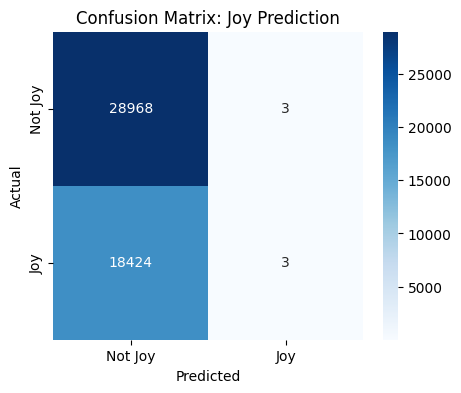

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Joy', 'Joy'], yticklabels=['Not Joy', 'Joy'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: Joy Prediction')
plt.show()
